### Spikerate by cue
- computation: http://localhost:8186/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/computations/3-compute-cued-spikerate-with-shuff.ipynb
- based on: http://localhost:8187/notebooks/tsainbur/Projects/github_repos/cdcp_chronic/notebooks/neural-analysis/spiketrain_analyses/tests/analyze-spikerate-differences-by-cue-with-shuffled-control.ipynb

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
# set to be lower priority
#os.nice(1)

In [3]:
interpolations = [
        "AE",
        "AF",
        "AG",
        "AH",
        "BE",
        "BF",
        "BG",
        "BH",
        "CE",
        "CF",
        "CG",
        "CH",
        "DE",
        "DF",
        "DG",
        "DH",
    ]

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas  as pd
from cdcp.paths import DATA_DIR, ensure_dir
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pathlib2 import Path
from tqdm.autonotebook import tqdm
pd.set_option('display.max_columns', 500)
from joblib import Parallel, delayed
from datetime import datetime
from joblib import Parallel, delayed
from functools import reduce
from sklearn.decomposition import PCA
from functools import reduce


In [6]:
from cdcp.visualization.colors import colors as cdcp_colors


In [7]:
import seaborn as sns
from cdcp.behavior.psychometric import FourParameterLogistic, fit_FourParameterLogistic
import scipy.stats
from cdcp.spiketrain_analysis.neurometric import (
    get_interp_points_dists_from_similarity_matrix,
)

In [8]:
from cdcp.paths import DATA_PATH_MAGPI, FIGURE_DIR, ensure_dir
from cdcp.general import save_fig

In [9]:
%matplotlib inline

In [10]:
# "2021-10-07_16-05-58_796914" '2021-10-06_13-30-08_899062' '2021-10-01_17-02-56_744915' 
statistics_timestamp = '2021-10-23_23-02-31_846685'# datetime.now().strftime("%Y-%m-%d_%H-%M-%S_%f")#
statistics_timestamp

'2021-10-23_23-02-31_846685'

In [11]:
birds = [
    ('B1597', '2021-05-14_12-40-20_423998', 'kilosort2_5'),
    ('B1188', '2021-05-31_18-52-29_558216', 'kilosort2_5'),
    ('B1595', '2021-07-10_16-42-47_090257', 'kilosort2'),
    #('B1276', '2021-07-14_11-14-02_257025', 'kilosort2'),
    ('B1426', '2021-07-14_11-29-39_657273', 'kilosort2'),
    ('B1432', '2021-06-01_15-14-38_561892', 'kilosort2_5'),
    ('B1170', '2021-06-01_21-01-26_519005', 'kilosort2_5'),
    ('B1244', '2021-07-14_12-57-45_546674', 'kilosort2'),
    ('B1593', '2021-06-28_18-13-24_826008', 'kilosort2_5'),
    ('B1248', '2021-07-03_18-08-01_063431', 'kilosort2_5'),
    # acute
    #('B1279', '2021-04-12_16-27-07_289527', 'kilosort2_5'),
    #('B1500', '2021-08-27_09-24-48_680961', 'kilosort2_5'),
    #('B1239', '2021-05-17_22-18-51_557635', 'kilosort2'),
    #('B1459', '2021-08-26_21-21-12_755614', 'kilosort2_5'),
]
birds_df = pd.DataFrame(birds, columns = ['bird', 'timestamp', 'sorter']).set_index('bird')

In [12]:
identifiers = ['spike_count',  'unit_location']# , 

In [13]:
n_interp_bins = 16

In [14]:
all_unit_statistics_df = []
for bird, timestamp, sorter in tqdm(birds, desc="birds"):

    unit_statistics_df_list = []
    for identifier in identifiers:
        unit_statistics_df = pd.read_pickle(
            DATA_DIR
            / "unit_statistics"
            / statistics_timestamp
            / identifier
            / "{}.pickle".format(bird)
        )
        unit_statistics_df_list.append(unit_statistics_df)
    print(bird, "nrows per", [len(i) for i in unit_statistics_df_list])

    # combine dfs
    unit_statistics_df = reduce(
        lambda x, y: pd.merge(x, y, on="unit", how="outer"), unit_statistics_df_list
    )
    unit_statistics_df["bird"] = bird

    all_unit_statistics_df.append(unit_statistics_df)
unit_statistics_df = pd.concat(all_unit_statistics_df)

birds:   0%|          | 0/9 [00:00<?, ?it/s]

B1597 nrows per [6750, 8711]
B1188 nrows per [510, 821]
B1595 nrows per [242, 325]
B1426 nrows per [93, 180]
B1432 nrows per [2157, 2364]
B1170 nrows per [1281, 1693]
B1244 nrows per [141, 150]
B1593 nrows per [7714, 13260]
B1248 nrows per [8698, 13184]


In [15]:
unit_statistics_df[:3]

,n_trials,n_cued_trials,n_incorrect_trials,n_correct_trials,n_reward_trials,n_passive_trials,n_active_trials,n_spikes,unit,hemisphere,labeled_region,estimated_nuclei,distance_to_estimated_nuclei,ML,AP,DV,bird
0,1390,1143,151,975,387,0,1390,24748,7569,NaN,NaN,Field_L,437.772,2144.25,2420.0,-822.499502,B1597
1,1273,1043,150,975,387,0,1273,350,7927,NaN,NaN,NCL,479.334,2757.25,2420.0,-782.499502,B1597
2,6279,540,106,559,226,5603,676,2445,5875,NaN,NaN,CMM,379.286,1931.25,2420.0,-802.499502,B1597


In [16]:
len(unit_statistics_df)

40688

In [17]:
# merge with categorical units
categorical_units_df = pd.read_pickle(DATA_DIR / 'categorical_unit_01_23_22.pickle')
categorical_units_df= categorical_units_df[categorical_units_df.categorical_unit == True]
unit_statistics_df_cat = pd.merge(unit_statistics_df, categorical_units_df, on = ['bird', 'unit'])
# subset categorical units
#unit_statistics_df_cat = unit_statistics_df_cat[unit_statistics_df_cat.categorical_unit == True]
unit_statistics_df = unit_statistics_df_cat
print(len(unit_statistics_df))

### merge with unit types
unit_type_df = pd.read_pickle(DATA_DIR / "unit_classes_01_23_22.pickle")
#unit_type_df = unit_type_df[["nuclei","AP","ML","DV","amplitude","template_amplitude","sr","fw","hw","bird","unit"]]
unit_statistics_df_ut = pd.merge(unit_statistics_df, unit_type_df, on = ['bird', 'unit'])
unit_statistics_df = unit_statistics_df_ut
print(len(unit_statistics_df))

6671
6671


In [18]:
unit_type_df[:3]

,fw,sr,unit_type,unit,bird,best_chan_templates,best_chan_templates_norm,amplitude
0,70.0,19.505140,2,6270,B1597,"[29.0, 28.94094094094094, 28.88188188188188, 2...","[0.04162189031853942, 0.04153712653652313, 0.0...",-515.25
1,86.0,7.202434,2,935,B1597,"[29.5, 29.47047047047047, 29.44094094094094, 2...","[0.07603293844777533, 0.07595682940028006, 0.0...",-294.00
2,120.0,13.687375,0,10839,B1597,"[42.75, 42.779529529529526, 42.80905905905906,...","[0.1011863087601332, 0.10125620312487042, 0.10...",-314.00


In [19]:
len(unit_statistics_df)

6671

In [20]:
len(unit_statistics_df_cat)

6671

In [21]:
len(categorical_units_df)

7923

In [22]:
unit_statistics_df = unit_statistics_df.drop(
    columns=[
        "best_chan_templates",
        "best_chan_templates_norm",
        "distance_to_estimated_nuclei",
        #"ML",
        #"AP",
        #"DV",
        "amplitude",
        "n_trials",
        #"n_cued_trials",
        "n_incorrect_trials",
        "n_correct_trials",
        "n_reward_trials",
        "n_passive_trials",
        "n_active_trials",
        "n_spikes",
        "hemisphere",
        "labeled_region",
        "fw",
    ]
)
unit_statistics_df[:3]

,n_cued_trials,unit,estimated_nuclei,ML,AP,DV,bird,categorical_unit,categoricality,sr,unit_type
0,1178,6270,NCL,2917.25,2420.0,-722.499502,B1597,True,0.425070,19.505140,2
1,1,935,Field_L,2344.25,2420.0,-822.499502,B1597,True,0.270426,7.202434,2
2,1967,10839,CMM,1764.25,2420.0,-742.499502,B1597,True,0.298817,13.687375,0


### Get cuing info

In [23]:
all_cuing_df = []
for bird, timestamp, sorter in tqdm(birds, desc="birds"):

    cuing_df = pd.read_pickle(
        DATA_DIR
        / "unit_statistics"
        / statistics_timestamp
        / "cued_trial_spikerate_z_scored_by_unit_shuffle"
        / "{}.pickle".format(bird)
    )
    print(bird, len(cuing_df))
    cuing_df["bird"] = bird

    all_cuing_df.append(cuing_df)
    
z_score_df  = pd.concat(all_cuing_df)

birds:   0%|          | 0/9 [00:00<?, ?it/s]

B1597 1518130
B1188 92203
B1595 14440
B1426 625
B1432 446528
B1170 121189
B1244 42173
B1593 1714936
B1248 1461812


In [24]:
z_score_df[:3]

,0,all_z_score_cue,all_z_score_cue_shuff,cue,interp,interp_point,n_spikerate_samples,n_zscore_samples,passive_active,sr,sr_shuffled,sr_z,sr_z_diff_between,sr_z_diff_within,sr_z_shuffled,unit,bird
0,NaN,"[-0.26925225332783936, -0.26925225332783936, -...","[-0.26925225332783936, -0.26925225332783936, -...",CR1,BF,9,5,12,passive,0.2,0.2,-0.217835,0.000000,0.082267,-0.217835,15067,B1597
1,NaN,"[-0.26925225332783936, -0.26925225332783936, -...","[-0.26925225332783936, -0.26925225332783936, -...",NC,BF,9,4,12,passive,0.0,0.0,-0.269252,0.056238,0.000000,-0.269252,15067,B1597
2,NaN,"[-0.26925225332783936, -0.26925225332783936, -...","[-0.26925225332783936, -0.26925225332783936, -...",CL1,BF,9,3,12,passive,0.0,0.0,-0.269252,0.082267,0.000000,-0.269252,15067,B1597


In [25]:
z_score_df.interp_point.values.astype(float)
# get side
z_score_df['side'] = 'L'
z_score_df.loc[z_score_df.interp_point.values.astype(float) > 7, 'side'] = 'R'

# remove non-categorical units
print(len(z_score_df))
z_score_df = z_score_df.merge(unit_statistics_df, on = ['bird', 'unit'])
print(len(z_score_df))

5412036
1386186


In [26]:
z_score_df[:3]

,0,all_z_score_cue,all_z_score_cue_shuff,cue,interp,interp_point,n_spikerate_samples,n_zscore_samples,passive_active,sr_x,sr_shuffled,sr_z,sr_z_diff_between,sr_z_diff_within,sr_z_shuffled,unit,bird,side,n_cued_trials,estimated_nuclei,ML,AP,DV,categorical_unit,categoricality,sr_y,unit_type
0,NaN,"[1.0192866744183064, 1.3258006353487133, 1.325...","[2.245342518139934, 0.09974479162708595, 1.938...",NC,AE,1,26,81,passive,6.384615,6.076923,0.524149,1.089467,1.019295,0.429837,6499,B1597,L,597,Field_L,2510.25,2420.0,-682.499502,True,0.378167,5.80392,1
1,NaN,"[1.938828557209527, -0.8197970911641346, -1.43...","[1.3258006353487133, 1.3258006353487133, -0.51...",CR1,AE,1,29,81,passive,5.206897,5.379310,0.163161,1.146253,1.020498,0.216009,6499,B1597,L,597,Field_L,2510.25,2420.0,-682.499502,True,0.378167,5.80392,1
2,NaN,"[-0.8197970911641346, -0.8197970911641346, 0.0...","[1.0192866744183064, 1.0192866744183064, -1.43...",CL1,AE,1,26,81,passive,5.846154,5.961538,0.359103,1.020498,1.146253,0.394470,6499,B1597,L,597,Field_L,2510.25,2420.0,-682.499502,True,0.378167,5.80392,1


### Load interpolation dataframe

In [27]:
# pickled dataframes
interp_df = pd.read_pickle(DATA_DIR / 'interp_df_melspec.pickle')

In [28]:
# pickled dataframes
stim_df = pd.read_pickle(DATA_DIR / 'stim_df_melspec.pickle')

In [29]:
interp_df[:2]

,L,R,prop,pt,z,x_x_interp,x_z_interp,audio,mel_spec
0,A,B,0.000000,0,"[1.0914186239242554, -0.4693475067615509, -1.8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.042301386813051e-06, 7.268283184203028e-07,...","[-12, -8, -44, -42, -54, -38, -39, -33, -48, -...","[[-39.531136, -39.316376, -38.798462, -38.2338..."
1,A,B,0.007874,1,"[1.070769041541993, -0.4643999143378941, -1.84...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[3.4460663300706074e-06, 8.483789883939608e-07...","[25, 31, 22, 15, -27, -39, -39, -52, -27, -27,...","[[-38.683086, -38.733887, -38.87696, -39.08884..."


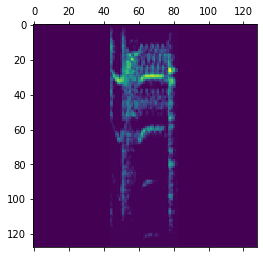

In [152]:
plt.matshow(interp_df.x_x_interp.values[0].reshape((128,128)))

In [30]:
audio = interp_df[(interp_df.L =='B') & (interp_df.R == 'F') & (interp_df.pt==127)].audio.values[0]

(0.0, 43912.0, -36024.65, 35797.65)

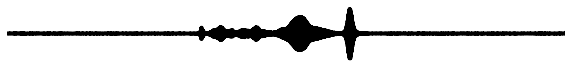

In [31]:
fig, ax = plt.subplots(figsize=(10,1))
plt.plot(audio, lw=4, color = 'k')
ax.set_xlim([0, len(audio)])
ax.axis('off')

### Create dataframe of samples per stimuli per unit

In [32]:
cues_to_plot = cues_this_unit = ["CL1", 'NC', 'CR1']

In [33]:
sample_df = pd.DataFrame(
    columns=[
        "bird",
        "unit",
        "interp_point",
        "interp",
        "n_samples",
        "srz_diff",
        "categoricality",
        "estimated_nuclei",
    ]
)
for bird in tqdm(np.unique(z_score_df.bird.values)):
    bird_df = z_score_df[z_score_df.cue.isin(cues_to_plot)]
    bird_df = bird_df[bird_df.n_cued_trials > 2500]
    bird_df = bird_df[bird_df.passive_active == "active"]
    bird_df = bird_df[
        [
            "cue",
            "bird",
            "unit",
            "interp_point",
            "n_spikerate_samples",
            "interp",
            "sr_z",
            "categoricality",
            "estimated_nuclei",
        ]
    ][bird_df.bird == bird]
    for unit in tqdm(np.unique(bird_df.unit.values), leave=False):
        for interp in bird_df[bird_df.unit == unit].interp.unique():
            for interp_point in bird_df[
                (bird_df.unit == unit) & (bird_df.interp == interp)
            ].interp_point.unique():
                #try:
                stim_df = bird_df[
                    (bird_df.interp == interp)
                    & (bird_df.unit == unit)
                    & (bird_df.interp_point == interp_point)
                ]
                if len(stim_df) < 3:
                    continue
                n_samples = np.min(stim_df.n_spikerate_samples)
                diff = (
                    stim_df[stim_df.cue == cues_to_plot[0]].sr_z.values[0]
                    - stim_df[stim_df.cue == cues_to_plot[-1]].sr_z.values[0]
                )
                sample_df.loc[len(sample_df)] = [
                    bird,
                    unit,
                    interp_point,
                    interp,
                    n_samples,
                    diff,
                    bird_df[bird_df.unit == unit].categoricality.values[0],
                    bird_df[bird_df.unit == unit].estimated_nuclei.values[0],
                ]
                #except:
                #    print(bird, unit, interp_point)

sample_df["side"] = 'L'
sample_df.loc[sample_df.interp_point > 7, 'side'] = 'R'
sample_df = sample_df[np.isnan(sample_df.srz_diff) == False]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

In [34]:
bird_df[:3]

,cue,bird,unit,interp_point,n_spikerate_samples,interp,sr_z,categoricality,estimated_nuclei
414,CR1,B1597,14159,8,17,AE,0.331052,0.304897,Field_L
416,NC,B1597,14159,8,11,AE,0.608065,0.304897,Field_L
418,CL1,B1597,14159,8,10,AE,-0.345263,0.304897,Field_L


In [35]:
sample_df[:3]

,bird,unit,interp_point,interp,n_samples,srz_diff,categoricality,estimated_nuclei,side
0,B1170,1027,9,AE,38,-0.206776,0.237348,CMM,R
1,B1170,1027,8,AE,39,0.019480,0.237348,CMM,R
2,B1170,1027,12,AE,28,0.137459,0.237348,CMM,R


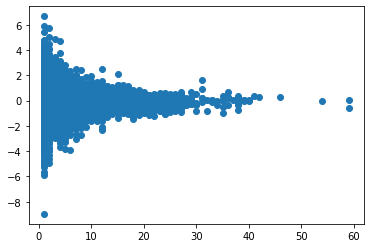

In [36]:
plt.scatter(sample_df.n_samples.values, sample_df.srz_diff.values)

#### passive

In [37]:
sample_df_passive = pd.DataFrame(
    columns=[
        "bird",
        "unit",
        "interp_point",
        "interp",
        "n_samples",
        "srz_diff",
        "categoricality",
    ]
)
for bird in tqdm(np.unique(z_score_df.bird.values)):
    #if bird != 'B1170':
    #    continue
    bird_df = z_score_df[z_score_df.cue.isin(cues_to_plot)]
    bird_df = bird_df[bird_df.n_cued_trials > 2500]
    bird_df = bird_df[bird_df.passive_active == "passive"]
    bird_df = bird_df[
        [
            "cue",
            "bird",
            "unit",
            "interp_point",
            "n_spikerate_samples",
            "interp",
            "sr_z",
            "categoricality",
        ]
    ][bird_df.bird == bird]
    for unit in tqdm(np.unique(bird_df.unit.values), leave=False):
        unit_df = bird_df[
                    (bird_df.unit == unit)
                ]
        for interp in unit_df.interp.unique():
            for interp_point in unit_df[(unit_df.interp == interp)
            ].interp_point.unique():
                #try:
                stim_df = unit_df[
                    (unit_df.interp == interp)
                    & (unit_df.unit == unit)
                    & (unit_df.interp_point == interp_point)
                ]
                
                if len(stim_df) < 3:
                    continue
                n_samples = np.min(stim_df.n_spikerate_samples)
                diff = (
                    stim_df[stim_df.cue == cues_to_plot[0]].sr_z.values[0]
                    - stim_df[stim_df.cue == cues_to_plot[-1]].sr_z.values[0]
                )
                sample_df_passive.loc[len(sample_df_passive)] = [
                    bird,
                    unit,
                    interp_point,
                    interp,
                    n_samples,
                    diff,
                    bird_df[bird_df.unit == unit].categoricality.values[0],
                ]
                

sample_df_passive["side"] = 'L'
sample_df_passive.loc[sample_df_passive.interp_point > 7, 'side'] = 'R'
sample_df_passive = sample_df_passive[np.isnan(sample_df_passive.srz_diff) == False]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/137 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/166 [00:00<?, ?it/s]

In [38]:
sample_df = sample_df.merge(sample_df_passive, on = ["bird", "unit", "interp_point", "interp"], suffixes=('_active', '_passive'))
sample_df["min_passive_active_samples"] = np.min(
    pd.concat([sample_df.n_samples_active, sample_df.n_samples_passive], axis=1).values,
    axis=1,
)
sample_df[:3]

,bird,unit,interp_point,interp,n_samples_active,srz_diff_active,categoricality_active,estimated_nuclei,side_active,n_samples_passive,srz_diff_passive,categoricality_passive,side_passive,min_passive_active_samples
0,B1170,1027,9,AE,38,-0.206776,0.237348,CMM,R,86,-0.095965,0.237348,R,38
1,B1170,1027,8,AE,39,0.019480,0.237348,CMM,R,79,0.226800,0.237348,R,39
2,B1170,1027,12,AE,28,0.137459,0.237348,CMM,R,80,-0.435841,0.237348,R,28


### Create a dataframe of unit info per bird

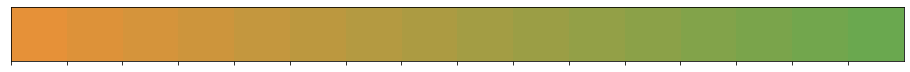

In [40]:
from matplotlib import gridspec

import seaborn as sns
import matplotlib
from cdcp.visualization.colors import colors as cdcp_colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", [cdcp_colors["reinforce"]["L"]["dark"], cdcp_colors["reinforce"]["R"]["dark"]]
)
pal = [cmap(i) for i in np.linspace(0, 1, n_interp_bins)]
sns.palplot(pal)

In [41]:
min_playbacks = 1000
bird_stats = {}
for bird, timestamp, sorter in tqdm(birds, desc='birds'):
    spikesorting_folder = (
        DATA_DIR / "spikesorting" / bird / birds_df.loc[bird].timestamp
    )
    recording_summary_df = pd.read_pickle(spikesorting_folder / "recording_df.pickle")

    # get units that are to be merged
    merged_units = pd.read_pickle(spikesorting_folder / "unit_clusters2.pickle")
    merged_units = merged_units.sort_values(by="n_playbacks", ascending=False)
    merged_units = merged_units[
        merged_units.n_playbacks.astype("float") > min_playbacks
    ]
    merged_units = merged_units.set_index("cluster_id")

    bird_stats[bird] = {
        'merged_units': merged_units,
        'spikesorting_folder': spikesorting_folder,
    }

birds:   0%|          | 0/9 [00:00<?, ?it/s]

In [100]:
def zero_one_norm(x):
    x = np.array(x).astype('float32')
    return (x - np.min(x)) / (np.max(x) - np.min(x))

In [235]:
def plot_cued_spikevector(trial_aligned_spikes_active, trial_aligned_spikes_passive, interp, ip, n_samples, axi=0, nex=1):
    fig = plt.figure(figsize=(3, 4))
    gs = gridspec.GridSpec(5, nex, height_ratios=[1.5, 1,3, 1, 3], hspace=0)
    # fig, axs = plt.subplots(ncols=nex, nrows=2, figsize=(20, 5))
    # ax = axs[0, axi]
    n_spikes_per_bin = int(n_samples)

    # plot trial
    
    interp_df_row = interp_df[
        (interp_df.L ==  interp[0])
        & (interp_df.R == row.interp[1])
        & ((interp_df.pt == trial_aligned_spikes_active.interp_point.values[0]))
    ]
    
    audio = interp_df_row.audio.values[0]
    
    spec = interp_df_row.x_x_interp.values[0].reshape((128,128))
    
    ax0 = plt.subplot(gs[0,0])
    ax0.set_xlim([0,2])
    ax0.set_ylim([0,1])
    
    ax0.spines['left'].set_linewidth(5) 
    ax0.spines['right'].set_linewidth(5) 
    ax0.spines['bottom'].set_linewidth(0) 
    ax0.spines['top'].set_linewidth(5) 
    ax0.set_facecolor("k")
    #ax0.plot(np.linspace(1,2, len(audio)), zero_one_norm(audio), color = 'k')
    ax0.matshow(spec, aspect='auto', extent = [1,2,0,1], cmap = "afmhot", origin='lower')
    ax0.set_xticks([])
    ax0.set_yticks([])
    
    for tdfi, trial_df in enumerate([trial_aligned_spikes_active, trial_aligned_spikes_passive]):
        line = 0
        ax = plt.subplot(gs[tdfi*2+2, axi])
        ax2 = plt.subplot(gs[tdfi*2+1, axi])
        ax2.set_xticks([])
        #ax2.set_title([interp, ip])
        for cue in cues_this_unit:
            cue_df = trial_df[trial_df.cue == cue]
            spike_times = cue_df.spike_times.values
            if len(spike_times) == 0:
                continue
            samps = np.random.choice(len(spike_times), n_spikes_per_bin, replace=False)
            for i, samp in enumerate(samps):
                color = cdcp_colors["cue"][cue[1]]["dark"]
                ax.vlines(
                    spike_times[samp][(spike_times[samp] > 1) & (spike_times[samp] <2)],
                    ymin=(line),
                    ymax=(line + 1),
                    color=pal[int(ip)],
                )
                if cue == "NC":
                    ax.vlines(
                        1 + spike_times[samp][(spike_times[samp] < 1) & (spike_times[samp] > 0)],
                        lw=1,
                        ymin=(line),
                        ymax=(line + 1),
                        color=pal[int(ip)],
                    )
                else:
                    color = cdcp_colors["cue"][cue[1]]["dark"]
                    ax.vlines(
                        spike_times[samp][(spike_times[samp] < 1) & (spike_times[samp] > 0)],
                        lw=1,
                        ymin=(line),
                        ymax=(line + 1),
                        color=color,
                    )
                line += 1

            # plot average
            sts = [
                get_spike_train_vector(
                    row,
                    nbins=100,
                    gaussian_sigma_ms=25,
                    return_gauss=True,
                    no_cue=False,
                    padding_s = 0.1
                )
                for idx, row in cue_df.iterrows()
            ]
            #breakme
            spiketrain_avg = np.nanmean(sts, axis=0)
            spiketrain_std = np.nanmean(sts, axis=0)
            spiketrain_sem = spiketrain_std / np.sqrt(len(spiketrain_std))

            ax2.plot(np.linspace(0,2, len(spiketrain_avg)), spiketrain_avg, color=cdcp_colors["cue_pal"][cue], lw=1)
            ax2.fill_between(
                np.linspace(0,2, len(spiketrain_avg)),
                spiketrain_avg - spiketrain_sem*3,
                spiketrain_avg + spiketrain_sem*3,
                color=cdcp_colors["cue_pal"][cue],
                alpha=0.25,
            )
            #breakme
            ax2.set_xlim([0, 2])
            ax.set_xlim([0, 2])
            ax.set_ylim([0, n_spikes_per_bin * len(cues_this_unit)])
            ax.set_yticks([])
            ax2.set_yticks([])
            ax.set_xticks([])
            ax.set_yticks([])
            ax.spines['left'].set_linewidth(5) 
            ax.spines['right'].set_linewidth(5) 
            ax.spines['bottom'].set_linewidth(5) 
            ax.spines['top'].set_linewidth(0) 
            ax2.spines['left'].set_linewidth(5) 
            ax2.spines['right'].set_linewidth(5) 
            ax2.spines['bottom'].set_linewidth(0) 
            ax2.spines['top'].set_linewidth(0) 

    return fig

In [228]:
from cdcp.spiketrain_analysis.spiketrain_utils import get_unit_spike_trains, bin_interp_points, get_spike_train_vector

In [229]:
n_interp_point_bins = 16
nex=100
axi = 0

In [230]:
sample_df[:3]

,bird,unit,interp_point,interp,n_samples_active,srz_diff_active,categoricality_active,estimated_nuclei,side_active,n_samples_passive,srz_diff_passive,categoricality_passive,side_passive,min_passive_active_samples
0,B1170,1027,9,AE,38,-0.206776,0.237348,CMM,R,86,-0.095965,0.237348,R,38
1,B1170,1027,8,AE,39,0.019480,0.237348,CMM,R,79,0.226800,0.237348,R,39
2,B1170,1027,12,AE,28,0.137459,0.237348,CMM,R,80,-0.435841,0.237348,R,28


In [231]:
units_to_sample = (
    ["B1170", 1301, "AE", 7, "CMM"],
    ["B1597", 4957, "AE", 14, "Field_L"],
    ["B1248", 3228, "BF", 1, "NCM"],
    ["B1593", 15834, "AE", 8, "NCL"],
)

In [237]:
save_figs = True

B1170 1301 AE 7 CMM


unit spike trains:   0%|          | 0/5 [00:00<?, ?it/s]

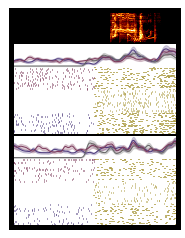

B1597 4957 AE 14 Field_L


unit spike trains:   0%|          | 0/33 [00:00<?, ?it/s]

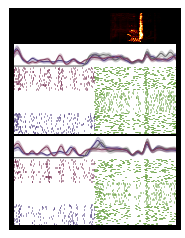

B1248 3228 BF 1 NCM


unit spike trains:   0%|          | 0/3 [00:00<?, ?it/s]

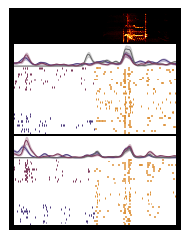

B1593 15834 AE 8 NCL


unit spike trains:   0%|          | 0/8 [00:00<?, ?it/s]

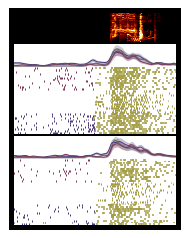

In [238]:
for bird, unit, interpolation, interpolation_point, region in units_to_sample:
    # unit info
    unit_to_plot = unit 
    bird = bird
    sorter = birds_df.loc[bird].sorter
    sort_units = bird_stats[bird]["merged_units"].loc[int(unit_to_plot)].sort_units
    spikesorting_folder = bird_stats[bird]["spikesorting_folder"]
    
    row = sample_df[(
        (sample_df.bird == bird) & 
        (sample_df.unit == str(unit)) & 
        (sample_df.interp == interpolation) & 
        (sample_df.interp_point == interpolation_point) 
    )
    ].iloc[0]
    print(bird, unit, row.interp, row.interp_point, row.estimated_nuclei)

    
    # get trials
    trial_aligned_spikes = get_unit_spike_trains(
        sort_units,
        spikesorting_folder,
        sorter,
        unit,
        trial_aligned_spikes_folder="trial_aligned_spikes_padding_100ms",
    )
    
    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].astype(int),
        n_interp_point_bins,
        flip_bins=True,
    )
    
    # get individual trial dataframe
    trial_aligned_spikes = trial_aligned_spikes[
        (trial_aligned_spikes.interp_point_binned == row.interp_point)
        & (trial_aligned_spikes.interp == row.interp)
    ]
    trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.cue.isin(cues_this_unit)]

    
    # remove passive
    trial_aligned_spikes_active = trial_aligned_spikes[trial_aligned_spikes.passive == False]
    trial_aligned_spikes_passive = trial_aligned_spikes[trial_aligned_spikes.passive]
   
    # plot
    plot_cued_spikevector(
        trial_aligned_spikes_active,
        trial_aligned_spikes_passive,
        interp=row.interp,
        ip=row.interp_point,
        n_samples=row.min_passive_active_samples,
        axi=0,
        nex=1,
    )
    
    if save_figs:
        ensure_dir((
            FIGURE_DIR
            / "neural_results"
            / "stimulus_spikerate"
        ))
        save_fig(
            FIGURE_DIR
            / "neural_results"
            / "cue_spikerate"
            / "sample-passive_active_{}_{}_{}_{}_{}".format(bird, unit, interpolation, interpolation_point, region),
            save_pdf=True,
            save_png=True,
        )  
    
    
    plt.show()
    # break

B1170 1301 AE 9 Field_L


B1248 3676 AE 12 NCM


unit spike trains:   0%|          | 0/8 [00:00<?, ?it/s]

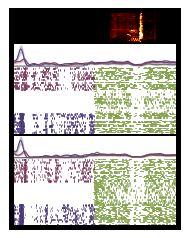

B1248 4112 BF 8 NCM


unit spike trains:   0%|          | 0/14 [00:00<?, ?it/s]

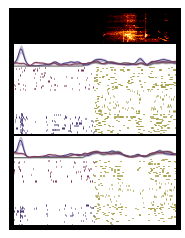

B1248 3676 AE 4 NCM


unit spike trains:   0%|          | 0/8 [00:00<?, ?it/s]

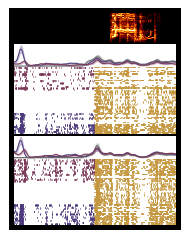

B1248 2503 BF 1 NCM


unit spike trains:   0%|          | 0/6 [00:00<?, ?it/s]

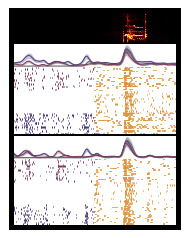

B1248 4112 AE 9 NCM


unit spike trains:   0%|          | 0/14 [00:00<?, ?it/s]

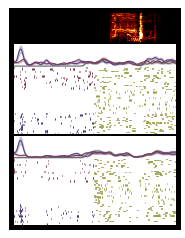

B1593 13962 BF 6 NCM


unit spike trains:   0%|          | 0/12 [00:00<?, ?it/s]

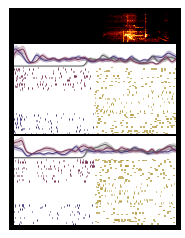

B1248 2503 AE 13 NCM


unit spike trains:   0%|          | 0/6 [00:00<?, ?it/s]

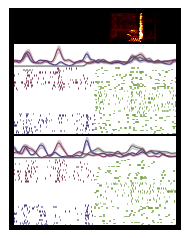

B1248 3676 BF 1 NCM


unit spike trains:   0%|          | 0/8 [00:00<?, ?it/s]

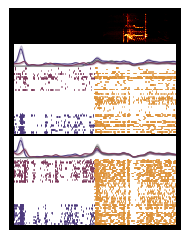

In [223]:
for idx, row in (
    sample_df[(sample_df.min_passive_active_samples > 15) & ((sample_df.estimated_nuclei == "NCM"))]
    .sort_values(by="min_passive_active_samples", ascending=False)[:nex]
    .iterrows()
):
    
    # unit info
    unit_to_plot = unit = row.unit
    bird = row.bird
    sorter = birds_df.loc[bird].sorter
    sort_units = bird_stats[bird]["merged_units"].loc[int(unit_to_plot)].sort_units
    spikesorting_folder = bird_stats[bird]["spikesorting_folder"]
    print(bird, unit, row.interp, row.interp_point, row.estimated_nuclei)
    # get trials
    trial_aligned_spikes = get_unit_spike_trains(
        sort_units,
        spikesorting_folder,
        sorter,
        unit,
        trial_aligned_spikes_folder="trial_aligned_spikes_padding_100ms",
    )
    
    # ensure interp point is an integer
    trial_aligned_spikes["interp_point_binned"] = bin_interp_points(
        trial_aligned_spikes["interp_point"].astype(int),
        n_interp_point_bins,
        flip_bins=True,
    )
    
    # get individual trial dataframe
    trial_aligned_spikes = trial_aligned_spikes[
        (trial_aligned_spikes.interp_point_binned == row.interp_point)
        & (trial_aligned_spikes.interp == row.interp)
    ]
    trial_aligned_spikes = trial_aligned_spikes[trial_aligned_spikes.cue.isin(cues_this_unit)]

    
    # remove passive
    trial_aligned_spikes_active = trial_aligned_spikes[trial_aligned_spikes.passive == False]
    trial_aligned_spikes_passive = trial_aligned_spikes[trial_aligned_spikes.passive]
   
    # plot
    plot_cued_spikevector(
        trial_aligned_spikes_active,
        trial_aligned_spikes_passive,
        interp=row.interp,
        ip=row.interp_point,
        n_samples=row.min_passive_active_samples,
        axi=0,
        nex=1,
    )
    plt.show()
    # break